In [28]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '5mm'
design.chips.main.size['size_y'] = '2.5mm'


gui = MetalGUI(design)

In [30]:
design.overwrite_enabled = True
design.delete_all_components()

In [31]:
from qiskit_metal.qlibrary.lumped.cap_n_interdigital import CapNInterdigital

Cap= CapNInterdigital(design, 'Cap', options= dict(south_width='10um',south_gap='6um',  
                                                   cap_gap_ground='6um',cap_width='1.3513um', 
                                                   cap_gap='0.8108um', chip='main',
                                                   cap_distance='50um',
                                                   pos_x='-1.25mm', pos_y='0mm', orientation='270', 
                                                   finger_length = '40um', trace_width='1um'))

gui.rebuild()


In [32]:
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled
p1 = LaunchpadWirebond(design, 'P1', options = dict(pos_x='2250um', pos_y='0um', orientation='180', lead_length='0um',chip='main'))
p2 = LaunchpadWirebond(design, 'P2', options = dict(pos_x='-2250um', pos_y='0um', orientation='0', lead_length='856.4866um',chip='main'))

gui.rebuild()


In [33]:
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround


otg_1 = OpenToGround(design, 'open_to_ground_1', options=dict(pos_x='1.25mm',  pos_y='0um', orientation='0'))
stg = ShortToGround(design, 'short_to_ground', options=dict(pos_x='-1.25mm',  pos_y='0um', orientation='180'))
rt_meander = RouteMeander(design, 'readout',  Dict(
        total_length='6 mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = dict(start_straight='100um'),
        pin_inputs=Dict(
            start_pin=Dict(component='open_to_ground_1', pin='open'),
            end_pin=Dict(component='Cap', pin='north_end')), ))

gui.rebuild()
gui.autoscale()

In [34]:
otg_p = OpenToGround(design, 'open_to_ground_p', options=dict(pos_x='1.271mm',  pos_y='40um', orientation='90'))

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from collections import OrderedDict
jogs = OrderedDict()
jogs[0] = ["L", '300um']
jogs[1] = ["R", '229um']
jogs[2] = ["R", '300um']


options = Dict(
    total_length= '1.352mm',
    fillet='99um',
    hfss_wire_bonds = True,
    pin_inputs=Dict(
        start_pin=Dict(
            component= 'P1',
            pin= 'tie'),
        end_pin=Dict(
            component= 'open_to_ground_p',
            pin= 'open')),
    lead=Dict(
        start_straight='0.75mm',
        end_straight='0mm',
        start_jogged_extension=jogs)
   )

pumpline = RouteMeander(design,'pumpline', options=options)
gui.rebuild()
gui.autoscale()

02:01PM 06s INFO [connect_meandered]: Zero meanders for pumpline
02:01PM 06s INFO [connect_meandered]: Zero meanders for pumpline


In [35]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_res = EPRanalysis(design, "hfss")

In [37]:
hfss = eig_res.sim.renderer

In [10]:
hfss.open_ansys(path_var='ANSYSEM_ROOT211')

In [38]:
hfss.connect_ansys()

INFO 02:03PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:03PM [load_ansys_project]: 	Opened Ansys App
INFO 02:03PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 02:03PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project3
INFO 02:03PM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]
INFO 02:03PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:03PM [connect]: 	Connected to project "Project3" and design "Readout" 😀 



In [39]:
hfss.activate_ansys_design("Readout", 'eigenmode')

INFO 02:03PM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]


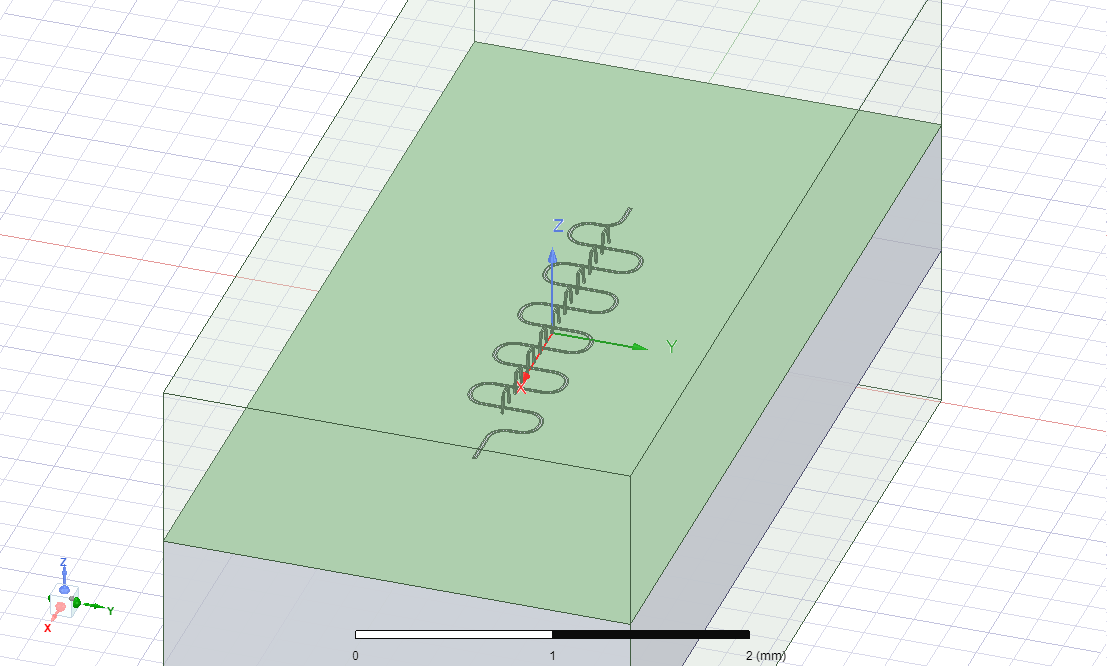

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [15]:
hfss.render_design(['short_to_ground', 'readout', 'open_to_ground_1'], [], box_plus_buffer=False)
hfss.save_screenshot()

In [16]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 20
setup.n_modes = 2
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

# Next 2 lines are counterinuitive, since there is no junction in this resonator.
# However, these are necessary to make pyEPR work correctly. Please do note delete
hfss.pinfo.design.set_variable('Lj', '10 nH')
hfss.pinfo.design.set_variable('Cj', '0 fF')



Number of eigenmodes to find             = 2
Number of simulation passes              = 20
Convergence freq max delta percent diff  = 0.1



'Cj'

In [17]:
eig_res.sim.close()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [18]:
hfss.start()

INFO 01:46PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:46PM [load_ansys_project]: 	Opened Ansys App
INFO 01:46PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:46PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project4
INFO 01:46PM [connect_design]: No active design found (or error getting active design).
INFO 01:46PM [connect]: 	 Connected to project "Project4". No design detected


True

In [40]:
eig_res.sim.convergence_t, eig_res.sim.convergence_f, _ = hfss.get_convergences()
eig_res.sim.plot_convergences()

02:03PM 58s INFO [get_f_convergence]: Saved convergences to C:\Users\Airplane\JupyterProject\hfss_eig_f_convergence.csv


02:04PM 10s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


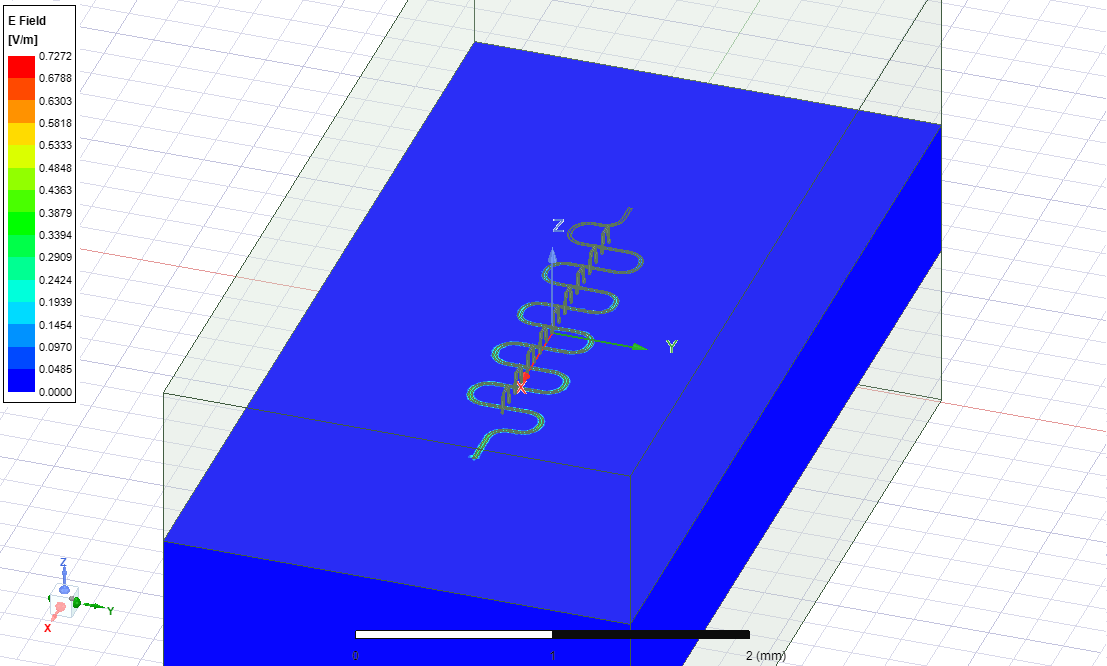

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [41]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [42]:
hfss.clear_fields(['Mag_E1'])

In [43]:
hfss.set_mode(2, "Setup")

INFO 02:04PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [44]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()

WindowsPath('C:/Users/Airplane/JupyterProject/ansys.png')

In [45]:
hfss.clear_fields(['Mag_E1'])

# Cap, Lp, OTG 보내기

In [46]:
hfss.render_design(['P1', 'P2'],[], box_plus_buffer=False)

In [47]:
hfss.render_design(['Cap'], [], box_plus_buffer=False)

In [48]:
hfss.render_design(['open_to_ground_p'],[], box_plus_buffer=False)

In [49]:
hfss.render_design(['pumpline'],[], box_plus_buffer=False)

In [50]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes=2
setup.passes = 10

print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10 nH')
pinfo.design.set_variable('Cj', '0 fF')




Number of eigenmodes to find             = 2
Number of simulation passes              = 10
Convergence freq max delta percent diff  = 0.1



'Cj'

In [51]:
hfss.disconnect_ansys() 

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [13]:
hfss.connect_ansys()

INFO 11:11AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:11AM [load_ansys_project]: 	Opened Ansys App
INFO 11:11AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 11:11AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project1
INFO 11:11AM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]
INFO 11:11AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 11:11AM [connect]: 	Connected to project "Project1" and design "Readout" 😀 



In [14]:
hfss.plot_convergences()

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


# Capacitance 

In [52]:
from qiskit_metal.analyses.quantization import LOManalysis
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer
c1 = LOManalysis(design, "q3d")

In [54]:
c1.sim.setup['freq_ghz']= '10Ghz'

In [55]:

c1.sim.run(components=['readout','short_to_ground','open_to_ground_1','Cap', 'P1', 'P2','pumpline', 'open_to_ground_p' ], 
           open_terminations=[('readout', 'start'), ('readout', 'end'),('pumpline', 'end')], box_plus_buffer=False)
c1.sim.capacitance_matrix

INFO 02:08PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:08PM [load_ansys_project]: 	Opened Ansys App
INFO 02:08PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 02:08PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project3
INFO 02:08PM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]
INFO 02:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:08PM [connect]: 	Connected to project "Project3" and design "Readout" 😀 

INFO 02:08PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:08PM [analyze]: Analyzing setup Setup


com_error: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024349), None)

In [56]:
c1.sim.close()

Warning! 6 COM references still alive
Ansys will likely refuse to shut down


In [60]:
c1.run()

INFO 02:15PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:15PM [load_ansys_project]: 	Opened Ansys App
INFO 02:15PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 02:15PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Airplane/OneDrive - skku.edu/문서/Ansoft/
	Project:   Project3
INFO 02:15PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:15PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:15PM [connect]: 	Connected to project "Project3" and design "Design_q3d" 😀 

INFO 02:15PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:15PM [analyze]: Analyzing setup Setup


com_error: (-2147352567, '예외가 발생했습니다.', (0, None, None, None, 0, -2147024349), None)

In [62]:
c1.sim.run

<bound method QSimulation.run of <qiskit_metal.analyses.simulation.lumped_elements.LumpedElementsSim object at 0x00000195F82CB070>>

In [63]:
c1.sim.capacitance_matrix

{}